# Hypothesis 1: Shift in Tipping Culture

#### We attempt to answer the question: **After adjusting for confounding factors such as trip duration and surcharges, do customers in 2019 exhibit different tipping behavior than those in 2014?**

In [145]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/taxidata_clean.csv', parse_dates=['trip_start_timestamp'])
df['year'] = df['trip_start_timestamp'].dt.year
df['pct_tip'] = 100 * df['tips'] / df['fare'].replace(0, np.nan)
df['hour'] = df['trip_start_timestamp'].dt.hour
df['dow'] = df['trip_start_timestamp'].dt.dayofweek
df['speed_mph'] = 3600 * df['trip_miles'] / df['trip_seconds'].replace(0, np.nan)

# 1. Exploratory Data Analysis and additional Preprocessing

As seen below, the dataset seemingly did not include any cash tips, as most tips came from riders who paid using credit card.

In [146]:
c = df.assign(has_tip=df['tips']>0).groupby(['year','payment_type']).agg(
    n=('tips','count'), n_tips=('has_tip','sum')
).assign(pct_tipped=lambda x: 100*x['n_tips']/x['n'])
print('2014:'); display(c.loc[2014])
print('2019:'); display(c.loc[2019])

2014:


,n,n_tips,pct_tipped
payment_type,,,
Cash,128779,1,0.0008
Credit Card,68575,66225,96.5731
Dispute,150,0,0.0000
No Charge,1483,0,0.0000
Unknown,295,113,38.3051


2019:


,n,n_tips,pct_tipped
payment_type,,,
Cash,93679,46,0.0491
Credit Card,98698,94319,95.5632
Dispute,69,0,0.0000
Mobile,3480,3433,98.6494
No Charge,319,5,1.5674
Pcard,2,0,0.0000
Prcard,2085,158,7.5779
Prepaid,9,0,0.0000
Unknown,1314,39,2.9680


Text(0, 0.5, 'Density')

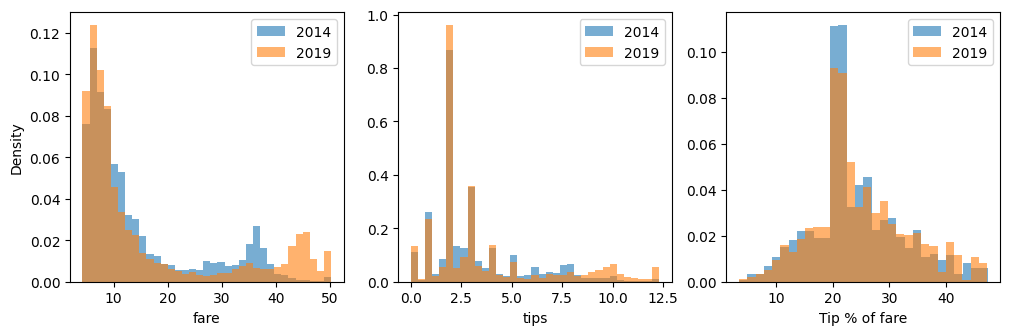

In [147]:
# CC users only: fare, tip, and tip % distributions, 2014 vs 2019
cc = df[(df['payment_type']=='Credit Card') & (df['fare']>0)].copy()
cc_pct = cc[cc['tips']>0][['year','pct_tip']].dropna()
q1, q3 = cc_pct['pct_tip'].quantile([0.25, 0.75])
cc_pct = cc_pct[(cc_pct['pct_tip']>=q1-1.5*(q3-q1)) & (cc_pct['pct_tip']<=q3+1.5*(q3-q1))]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
for col, ax_ in zip(['fare', 'tips'], ax[:2]):
    for y in [2014, 2019]:
        s = cc[cc['year']==y][col].clip(cc[col].quantile(0.01), cc[col].quantile(0.99))
        ax_.hist(s, bins=35, alpha=0.6, label=y, density=True)
    ax_.set_xlabel(col); ax_.legend()
for y in [2014, 2019]:
    ax[2].hist(cc_pct[cc_pct['year']==y]['pct_tip'], bins=30, alpha=0.6, label=y, density=True)
ax[2].set_xlabel('Tip % of fare'); ax[2].legend()
ax[0].set_ylabel('Density')

### Speed: 2014 vs 2019

Speed (mph) = trip_miles / (trip_seconds/3600). Trips with trip_seconds ≤ 0 excluded.

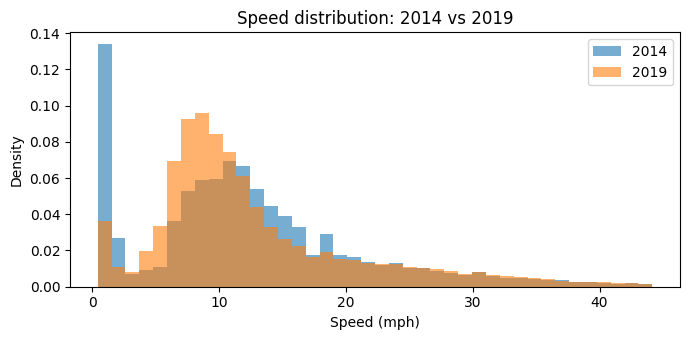

2014: mean=12.35 mph, median=11.22
2019: mean=12.74 mph, median=10.34


In [148]:
sp = df[df['trip_seconds']>0][['year','speed_mph']].dropna()
sp = sp[sp['speed_mph'].between(sp['speed_mph'].quantile(0.01), sp['speed_mph'].quantile(0.99))]

fig, ax = plt.subplots(figsize=(7, 3.5))
for y in [2014, 2019]:
    ax.hist(sp[sp['year']==y]['speed_mph'], bins=40, alpha=0.6, label=y, density=True)
ax.set_xlabel('Speed (mph)'); ax.set_ylabel('Density'); ax.legend()
ax.set_title('Speed distribution: 2014 vs 2019')
plt.tight_layout(); plt.show()

y14, y19 = sp[sp['year']==2014]['speed_mph'], sp[sp['year']==2019]['speed_mph']
print(f'2014: mean={y14.mean():.2f} mph, median={y14.median():.2f}')
print(f'2019: mean={y19.mean():.2f} mph, median={y19.median():.2f}')

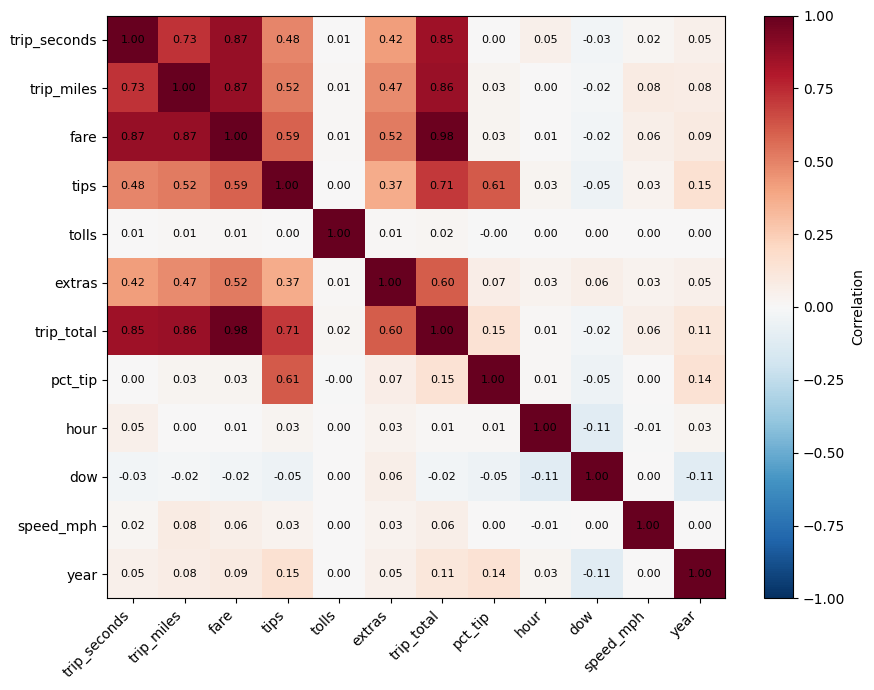

In [149]:
num_cols = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'pct_tip', 'hour', 'dow', 'speed_mph', 'year']
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticklabels(num_cols)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f'{corr.iloc[i,j]:.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

To choose confouding factors, we take a look at the available variables and decide on the `trip_seconds`, `trip_miles`, `fare`, `extras` and `speed_mph`.

### Preprocessing validation: confounding variables

Check that `trip_seconds`, `trip_miles`, `fare`, `extras`, `speed_mph` are valid for the analysis subset (CC, fare>0). Drop invalid rows. Use `df_cc` for subsequent modeling.

In [150]:
confound_cols = ['trip_seconds', 'trip_miles', 'fare', 'extras', 'speed_mph']
mask_cc = (df['payment_type'] == 'Credit Card') & (df['fare'] > 0)
df_cc = df[mask_cc].copy()

print('Validity checks (CC, fare>0):')
for c in confound_cols:
    n_na = df_cc[c].isna().sum()
    n_neg = (df_cc[c] < 0).sum()
    n_zero = (df_cc[c] == 0).sum() if c != 'extras' else 'N/A' 
    print(f'  {c:14s}: NaN={n_na:,}, neg={n_neg:,}', end='')
    if c != 'extras':
        print(f', zero={n_zero:,}')
    else:
        print()

# Additional filters: drop rows with invalid confounding vars
valid = (
    (df_cc['trip_seconds'] > 0) &
    (df_cc['trip_miles'] > 0) &
    (df_cc['fare'] > 0) &
    (df_cc['extras'] >= 0) &
    (df_cc['speed_mph'].notna()) &
    (df_cc['speed_mph'] > 0) &
    (df_cc['speed_mph'] <= 100)
)
dropped = df_cc[~valid]
df_cc = df_cc[valid]
n_drop = len(dropped)
print(f'\nDropped {n_drop} rows with invalid confounders. Final n={len(df_cc):,}')

Validity checks (CC, fare>0):
  trip_seconds  : NaN=0, neg=0, zero=0
  trip_miles    : NaN=0, neg=0, zero=0
  fare          : NaN=0, neg=0, zero=0
  extras        : NaN=0, neg=0
  speed_mph     : NaN=0, neg=0, zero=0

Dropped 32 rows with invalid confounders. Final n=167,241


# 2. Methodology

## Global Test — Doubly Robust Local Permutation

We test the global null hypothesis:

$$H_0: \text{Year} \perp \text{tips} \mid Z = (\text{fare, extras, trip\_seconds, trip\_miles, speed\_mph})$$

**Steps:**
1. Fit OLS: `tips ~ fare + extras + trip_seconds + trip_miles + speed_mph`. Compute residuals $\hat{r}_i$.
2. Test statistic: $T = \bar{\hat{r}}_{2019} - \bar{\hat{r}}_{2014}$
3. Create bins by 10% quantiles of fare (10 bins). Permute year labels within each bin to generate null distribution.
4. Two-sided p-value with $+1/+1$ correction.

### Step 1: Outcome regression (no year)

In [ ]:
import statsmodels.api as sm
from scipy import stats

SEED = 42
M_PERM = 1000
ALPHA = 0.05
rng = np.random.default_rng(SEED)

df_cc['year_dummy'] = (df_cc['year'] == 2019).astype(int)
CONFOUNDERS = ['fare', 'extras', 'trip_seconds', 'trip_miles', 'speed_mph']

# ── Step 1: OLS ──
X_no_year = df_cc[CONFOUNDERS].copy()
X_no_year.insert(0, 'const', 1.0)
Y = df_cc['tips'].values

ols_no_year = sm.OLS(Y, X_no_year).fit()
df_cc['residual'] = ols_no_year.resid

# ── Bins: 10% quantiles of fare ──
fare_deciles = pd.qcut(df_cc['fare'], q=10, labels=False, duplicates='drop')
bin_labels = np.array([f'D{int(x):02d}' for x in fare_deciles + 1])
df_cc['perm_bin'] = pd.Categorical(bin_labels, categories=sorted(np.unique(bin_labels)), ordered=True)

print(ols_no_year.summary())
print(f"\nNumber of bins: {df_cc['perm_bin'].nunique()}")
print(f"\nObservations per bin:")
bin_counts = df_cc.groupby('perm_bin', observed=True).agg(
    n=('year_dummy', 'count'),
    n_2014=('year_dummy', lambda x: (x == 0).sum()),
    n_2019=('year_dummy', 'sum')
).assign(p_2019=lambda x: x['n_2019'] / x['n']).sort_index(ascending=True)
print(bin_counts.to_string())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                 7.194e+04
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:28:41   Log-Likelihood:            -3.1837e+05
No. Observations:              167241   AIC:                         6.368e+05
Df Residuals:                  167235   BIC:                         6.368e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8246      0.012     66.259   

### Visual assumption checks: regression & exchangeability

/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


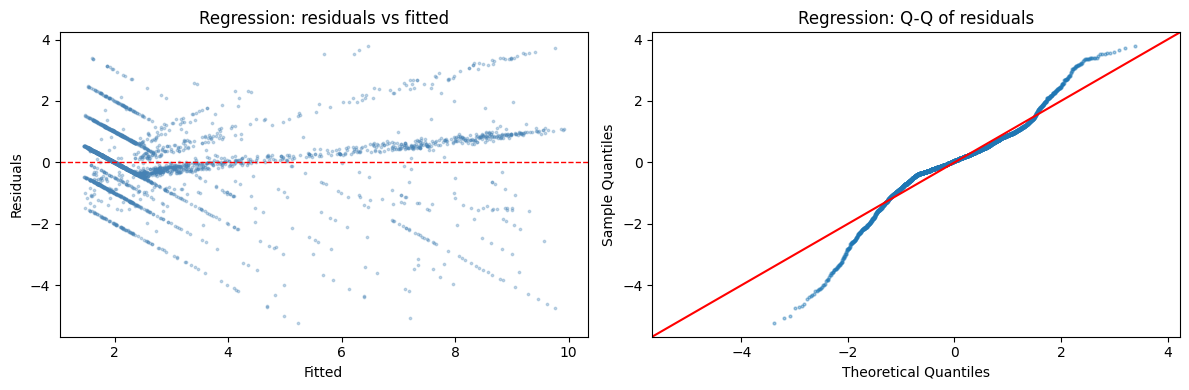

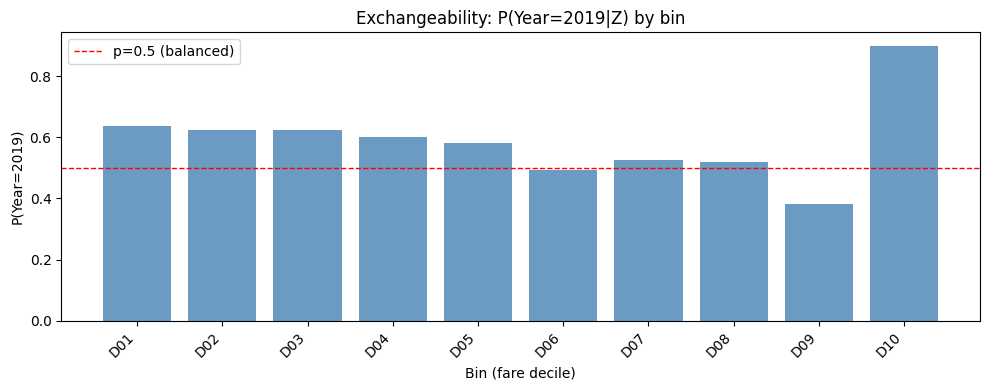

In [152]:
# ── Brief visual checks: regression & exchangeability ──

# Subsample and limit outliers for clearer visualization
resid, fitted = ols_no_year.resid.values, ols_no_year.fittedvalues.values
idx = np.random.RandomState(SEED).choice(len(resid), size=min(3000, len(resid)), replace=False)
r, f = resid[idx], fitted[idx]
# Clip to 1st–99th percentile to reduce outlier dominance
r_lo, r_hi = np.percentile(r, 1), np.percentile(r, 99)
f_lo, f_hi = np.percentile(f, 1), np.percentile(f, 99)
mask = (r >= r_lo) & (r <= r_hi) & (f >= f_lo) & (f <= f_hi)
r_plot, f_plot = r[mask], f[mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Regression: residuals vs fitted & Q-Q
axes[0].scatter(f_plot, r_plot, s=3, alpha=0.3, color='steelblue')
axes[0].axhline(0, color='red', ls='--', lw=1)
axes[0].set_xlabel('Fitted'); axes[0].set_ylabel('Residuals')
axes[0].set_title('Regression: residuals vs fitted')

# Q-Q on subsample
sm.qqplot(r_plot, line='45', ax=axes[1], markersize=2, alpha=0.4, color='steelblue')
axes[1].set_title('Regression: Q-Q of residuals')

plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
bc = bin_counts.reset_index().sort_values('perm_bin', ascending=True)
bars = ax.bar(range(len(bc)), bc['p_2019'], color='steelblue', alpha=0.8)
ax.axhline(0.5, color='red', ls='--', lw=1, label='p=0.5 (balanced)')
ax.set_xticks(range(len(bc)))
ax.set_xticklabels(bc['perm_bin'], rotation=45, ha='right')
ax.set_ylabel('P(Year=2019)'); ax.set_xlabel('Bin (fare decile)')
ax.set_title('Exchangeability: P(Year=2019|Z) by bin')
ax.legend()
plt.tight_layout(); plt.show()

### Steps 2–4: Local permutation test

In [ ]:
#  Local permutation test 
residuals = df_cc['residual'].values
year_labels = df_cc['year_dummy'].values
bin_codes, _ = pd.factorize(df_cc['perm_bin'])

# Pre-compute indices per bin (only bins with both years)
bin_indices = {}
for b in np.unique(bin_codes):
    idx = np.where(bin_codes == b)[0]
    if len(np.unique(year_labels[idx])) == 2:
        bin_indices[b] = idx

# Observed test statistic  T = mean | 2019 − mean | 2014
T_obs = residuals[year_labels == 1].mean() - residuals[year_labels == 0].mean()

# Permute year labels within bins
null_T = np.empty(M_PERM)
for m in range(M_PERM):
    shuffled_years = year_labels.copy()
    for b, idx in bin_indices.items():
        block = shuffled_years[idx]
        rng.shuffle(block)
        shuffled_years[idx] = block
    null_T[m] = residuals[shuffled_years == 1].mean() - residuals[shuffled_years == 0].mean()

# Two-sided p-value with +1/+1 correction
p_global = (1 + np.sum(np.abs(null_T) >= np.abs(T_obs))) / (1 + M_PERM)

print(f"T_obs (mean resid 2019 − mean resid 2014): {T_obs:+.6f}")
print(f"p-value (two-sided):                       {p_global:.4f}")
if p_global < ALPHA:
    print(f"=> REJECT H0 at alpha={ALPHA}")
else:
    print(f"=> Fail to reject H0 at alpha={ALPHA}")

T_obs (mean resid 2019 − mean resid 2014): +0.078875
p-value (two-sided):                       0.0010
=> REJECT H0 at alpha=0.05


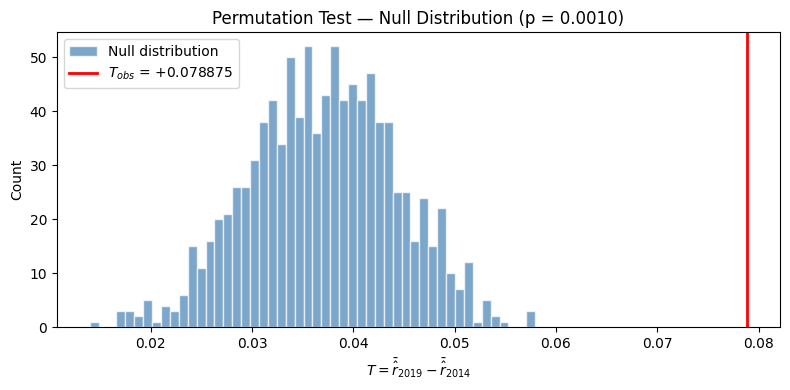

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_T, bins=50, edgecolor='white', alpha=0.7, color='steelblue', label='Null distribution')
ax.axvline(T_obs, color='red', lw=2, label=f'$T_{{obs}}$ = {T_obs:+.6f}')
ax.set_xlabel('$T = \\bar{\\hat{r}}_{2019} - \\bar{\\hat{r}}_{2014}$')
ax.set_ylabel('Count')
ax.set_title(f'Permutation Test — Null Distribution (p = {p_global:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

## Stage B: Per-Community-Area Tests

A natural follow-up: **in which areas** did tipping behavior change?

For each community area $i = 1, \ldots, m$:
1. Subset to rides from area $i$
2. Fit a local regression (same covariates, no year), compute residuals
3. Run the same doubly-robust local permutation test (bins = 10% quantiles of fare, same as before)
4. Obtain p-value $p_j$

In [155]:
# Chicago community area names
CA_NAMES = {
    1: "Rogers Park", 2: "West Ridge", 3: "Uptown", 4: "Lincoln Square",
    5: "North Center", 6: "Lake View", 7: "Lincoln Park", 8: "Near North Side",
    9: "Edison Park", 10: "Norwood Park", 11: "Jefferson Park",
    12: "Forest Glen", 13: "North Park", 14: "Albany Park",
    15: "Portage Park", 16: "Irving Park", 17: "Dunning",
    18: "Montclare", 19: "Belmont Cragin", 20: "Hermosa",
    21: "Avondale", 22: "Logan Square", 23: "Humboldt Park",
    24: "West Town", 25: "Austin", 26: "West Garfield Park",
    27: "East Garfield Park", 28: "Near West Side", 29: "North Lawndale",
    30: "South Lawndale", 31: "Lower West Side", 32: "Loop",
    33: "Near South Side", 34: "Armour Square", 35: "Douglas",
    36: "Oakland", 37: "Fuller Park", 38: "Grand Boulevard",
    39: "Kenwood", 40: "Washington Park", 41: "Hyde Park",
    42: "Woodlawn", 43: "South Shore", 44: "Chatham",
    45: "Avalon Park", 46: "South Chicago", 47: "Burnside",
    48: "Calumet Heights", 49: "Roseland", 50: "Pullman",
    51: "South Deering", 52: "East Side", 53: "West Pullman",
    54: "Riverdale", 55: "Hegewisch", 56: "Garfield Ridge",
    57: "Archer Heights", 58: "Brighton Park", 59: "McKinley Park",
    60: "Bridgeport", 61: "New City", 62: "West Elsdon",
    63: "Gage Park", 64: "Clearing", 65: "West Lawn",
    66: "Chicago Lawn", 67: "West Englewood", 68: "Englewood",
    69: "Greater Grand Crossing", 70: "Ashburn", 71: "Auburn Gresham",
    72: "Beverly", 73: "Washington Heights", 74: "Mount Greenwood",
    75: "Morgan Park", 76: "O'Hare", 77: "Edgewater",
}

MIN_PER_YEAR = 50

# Drop rows with missing pickup area
df_cc = df_cc.dropna(subset=['pickup_community_area'])
df_cc['pickup_community_area'] = df_cc['pickup_community_area'].astype(int)

# Check which areas qualify
area_counts = df_cc.groupby(['pickup_community_area', 'year']).size().unstack(fill_value=0)
qualified = area_counts[(area_counts[2014] >= MIN_PER_YEAR) & (area_counts[2019] >= MIN_PER_YEAR)]
print(f"Areas with >= {MIN_PER_YEAR} rides in both years: {len(qualified)} / {df_cc['pickup_community_area'].nunique()}")
print(f"Total rides in qualified areas: {df_cc[df_cc['pickup_community_area'].isin(qualified.index)].shape[0]:,}")

Areas with >= 50 rides in both years: 21 / 70
Total rides in qualified areas: 166,089


In [ ]:

def local_perm_test(data, confounders=CONFOUNDERS, m_perm=M_PERM, rng=rng):
    """
    Doubly-robust local permutation test for a single area.
    
    Returns dict with T_obs, p_value, sample sizes, raw effect, null distribution.
    """
    Y_loc = data['tips'].values
    T_loc = data['year_dummy'].values
    
    # Local regression (same covariates, no year)
    X_loc = data[confounders].copy().reset_index(drop=True)
    X_loc.insert(0, 'const', 1.0)
    
    try:
        model = sm.OLS(Y_loc, X_loc).fit()
        resid = model.resid
    except Exception:
        return None
    
    # Local bins: same as Stage A — 10% quantiles of fare
    try:
        fare_deciles = pd.qcut(data['fare'], q=10, labels=False, duplicates='drop')
    except ValueError:
        fare_deciles = pd.qcut(data['fare'], q=2, labels=False, duplicates='drop')
    bin_codes_loc = fare_deciles
    
    # Pre-compute bin indices (bins with both years)
    local_bin_idx = {}
    for b in np.unique(bin_codes_loc):
        idx = np.where(bin_codes_loc == b)[0]
        if len(np.unique(T_loc[idx])) == 2:
            local_bin_idx[b] = idx
    
    # Observed test statistic
    T_obs_loc = resid[T_loc == 1].mean() - resid[T_loc == 0].mean()
    
    # Permutation null
    null_vals = np.empty(m_perm)
    for i in range(m_perm):
        sh = T_loc.copy()
        for b, idx in local_bin_idx.items():
            block = sh[idx]
            rng.shuffle(block)
            sh[idx] = block
        null_vals[i] = resid[sh == 1].mean() - resid[sh == 0].mean()
    
    p_val = (1 + np.sum(np.abs(null_vals) >= np.abs(T_obs_loc))) / (1 + m_perm)
    
    effect_raw = Y_loc[T_loc == 1].mean() - Y_loc[T_loc == 0].mean()
    
    return {
        'T_obs': T_obs_loc,
        'p_value': p_val,
        'n_2014': int((T_loc == 0).sum()),
        'n_2019': int((T_loc == 1).sum()),
        'effect_raw': effect_raw,
        'null_dist': null_vals,
    }

# Run for all qualified areas
results = []
for area in qualified.index:
    subset = df_cc[df_cc['pickup_community_area'] == area].copy().reset_index(drop=True)
    out = local_perm_test(subset)
    if out is None:
        continue
    out['area_id'] = area
    out['area_name'] = CA_NAMES.get(area, f'Area {area}')
    results.append(out)
    
print(f"Successfully tested {len(results)} areas")

Successfully tested 21 areas


## Stage C: Multiple Testing Corrections

### Bonferroni correction (naive)

Reject $H_j$ if $p_j \leq \alpha / m$. This controls the **family-wise error rate** (FWER) $\leq \alpha$, but is conservative — it may miss real effects.

### Benjamini-Hochberg (BH) procedure

Sort p-values: $p_{(1)} \leq \cdots \leq p_{(m)}$. Reject $p_{(1)}, \ldots, p_{(\hat k)}$ where $\hat k = \max\{k : p_{(k)} \leq \frac{\alpha k}{m}\}$.


In [171]:
# ── Build results dataframe ──

res_df = pd.DataFrame([{
    'area_id': r['area_id'],
    'area_name': r['area_name'],
    'n_2014': r['n_2014'],
    'n_2019': r['n_2019'],
    'n': r['n_2014'] + r['n_2019'],
    'T_obs': r['T_obs'],
    'effect_raw': r['effect_raw'],
    'raw_p': r['p_value'],
} for r in results])

res_df = res_df.sort_values('raw_p').reset_index(drop=True)
m = len(res_df)
res_df['rank'] = np.arange(1, m + 1)

# ── 1. Bonferroni correction ──
res_df['bonf_adj_p'] = np.minimum(res_df['raw_p'] * m, 1.0)
res_df['bonf_reject'] = res_df['raw_p'] <= ALPHA / m
n_bonf = res_df['bonf_reject'].sum()

print(f"Number of hypotheses (m): {m}")
print(f"\n--- Bonferroni (FWER control) ---")
print(f"Threshold: alpha/m = {ALPHA}/{m} = {ALPHA/m:.4f}")
print(f"Bonferroni rejections: {n_bonf}")

# ── 2. BH procedure ──
res_df['bh_threshold'] = res_df['rank'] / m * ALPHA

# BH: reject all p_(k) where p_(k) <= alpha * k / m, up to max such k
res_df['bh_reject'] = res_df['raw_p'] <= res_df['bh_threshold']
if res_df['bh_reject'].any():
    k_hat = res_df[res_df['bh_reject']].index.max() + 1  # +1 because 0-indexed
    res_df.loc[:res_df[res_df['bh_reject']].index.max(), 'bh_reject'] = True
else:
    k_hat = 0

# BH-adjusted p-values
res_df['bh_adj_p'] = np.minimum(res_df['raw_p'] * m / res_df['rank'], 1.0)
res_df['bh_adj_p'] = res_df['bh_adj_p'][::-1].cummin()[::-1]

print(f"\n--- Benjamini-Hochberg (FDR control) ---")
print(f"BH discoveries (k_hat): {k_hat}")
print(f"FDR control level:      {ALPHA}")


Number of hypotheses (m): 21

--- Bonferroni (FWER control) ---
Threshold: alpha/m = 0.05/21 = 0.0024
Bonferroni rejections: 3

--- Benjamini-Hochberg (FDR control) ---
BH discoveries (k_hat): 3
FDR control level:      0.05


# 3. Results

In [165]:
# ── Results table ──
display_cols = ['area_name', 'n', 'effect_raw', 'T_obs', 'raw_p',
                'bonf_adj_p', 'bonf_reject', 'bh_adj_p', 'bh_reject']

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
res_df[display_cols]

,area_name,n,effect_raw,T_obs,raw_p,bh_adj_p,bh_reject
0,Near North Side,51765,0.0111,0.0666,0.0010,0.0105,True
1,O'Hare,18564,1.5197,0.2225,0.0010,0.0105,True
2,Near West Side,16324,-0.0773,0.0652,0.0020,0.0140,True
3,Lake View,7983,0.4290,0.0710,0.0230,0.1091,False
4,Garfield Ridge,5134,1.2749,0.2002,0.0260,0.1091,False
5,North Center,483,1.1404,0.2603,0.1069,0.3287,False
6,Hyde Park,686,0.8331,0.2174,0.1329,0.3287,False
7,Uptown,1579,0.4451,0.1087,0.1399,0.3287,False
8,Armour Square,141,1.0332,0.3324,0.1409,0.3287,False
9,Near South Side,5191,0.4945,0.0565,0.2547,0.4685,False


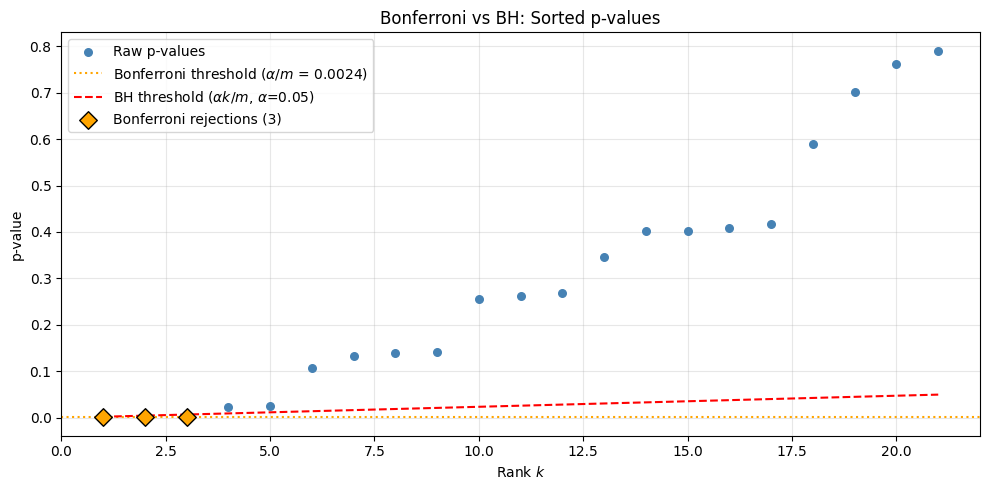

In [176]:
#  sorted p-values vs Bonferroni & BH thresholds 
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(res_df['rank'], res_df['raw_p'], color='steelblue', s=30, zorder=3, label='Raw p-values')

# Bonferroni threshold 
ax.axhline(ALPHA / m, color='orange', ls=':', lw=1.5, 
           label=f'Bonferroni threshold ($\\alpha/m$ = {ALPHA/m:.4f})')

# BH threshold
ax.plot(res_df['rank'], res_df['bh_threshold'], color='red', ls='--', lw=1.5, 
        label=f'BH threshold ($\\alpha k / m$, $\\alpha$={ALPHA})')

# Highlight Bonferroni rejections
if n_bonf > 0:
    ax.scatter(res_df[res_df['bonf_reject']]['rank'], 
               res_df[res_df['bonf_reject']]['raw_p'],
               color='orange', s=80, zorder=5, edgecolors='black', marker='D',
               label=f'Bonferroni rejections ({n_bonf})')

# Highlight BH discoveries (those not already caught by Bonferroni)
bh_only = res_df['bh_reject'] & ~res_df['bonf_reject']
if bh_only.any():
    ax.scatter(res_df[bh_only]['rank'], 
               res_df[bh_only]['raw_p'],
               color='crimson', s=50, zorder=4, edgecolors='black',
               label=f'BH-only discoveries ({bh_only.sum()})')

ax.set_xlabel('Rank $k$')
ax.set_ylabel('p-value')
ax.set_title(f'Bonferroni vs BH: Sorted p-values')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

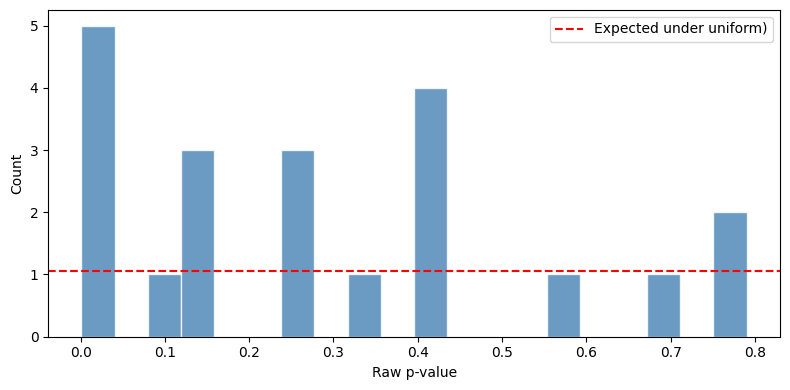

In [177]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res_df['raw_p'], bins=20, edgecolor='white', color='steelblue', alpha=0.8)
ax.axhline(m / 20, color='red', ls='--', lw=1.5, label=f'Expected under uniform)')
ax.set_xlabel('Raw p-value')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.show()

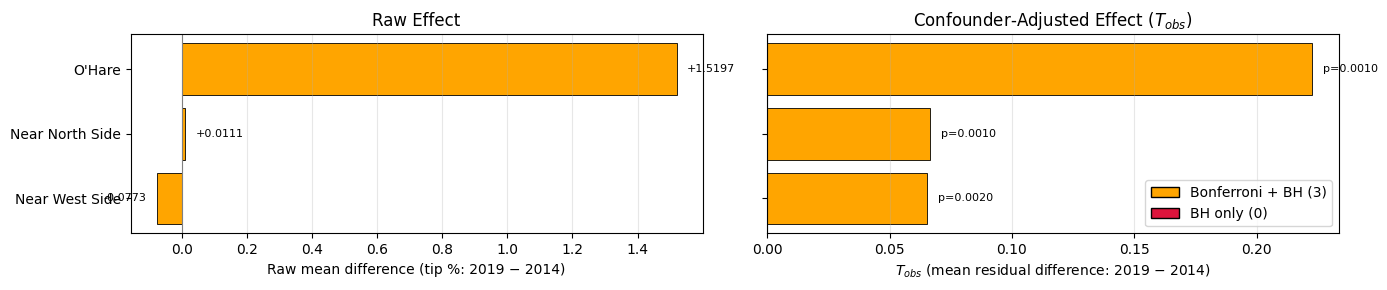

In [180]:
from matplotlib.patches import Patch

# ── Horizontal bar plots: raw mean difference & T_obs for BH discoveries ──
disc = res_df[res_df['bh_reject']].copy()
disc = disc.sort_values('T_obs')  # order by T statistic

colors = ['orange' if b else 'crimson' for b in disc['bonf_reject']]
h = max(3, 0.7 * len(disc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, h), sharey=True)

# ── Left panel: raw mean difference ──
ax1.barh(disc['area_name'], disc['effect_raw'], color=colors, edgecolor='black', linewidth=0.6)
ax1.axvline(0, color='grey', ls='-', lw=0.8)
ax1.set_xlabel('Raw mean difference (tip %: 2019 − 2014)')
ax1.set_title('Raw Effect')
for i, (_, row) in enumerate(disc.iterrows()):
    offset = 0.02 * (disc['effect_raw'].abs().max())
    x_pos = row['effect_raw'] + (offset if row['effect_raw'] >= 0 else -offset)
    ha = 'left' if row['effect_raw'] >= 0 else 'right'
    ax1.text(x_pos, i, f"{row['effect_raw']:+.4f}", va='center', ha=ha, fontsize=8)
ax1.grid(True, axis='x', alpha=0.3)

# ── Right panel: T statistic (confounder-adjusted) ──
ax2.barh(disc['area_name'], disc['T_obs'], color=colors, edgecolor='black', linewidth=0.6)
ax2.axvline(0, color='grey', ls='-', lw=0.8)
ax2.set_xlabel('$T_{obs}$ (mean residual difference: 2019 − 2014)')
ax2.set_title('Confounder-Adjusted Effect ($T_{obs}$)')
for i, (_, row) in enumerate(disc.iterrows()):
    offset = 0.02 * (disc['T_obs'].abs().max())
    x_pos = row['T_obs'] + (offset if row['T_obs'] >= 0 else -offset)
    ha = 'left' if row['T_obs'] >= 0 else 'right'
    ax2.text(x_pos, i, f"p={row['raw_p']:.4f}", va='center', ha=ha, fontsize=8)
ax2.grid(True, axis='x', alpha=0.3)

# Legend
legend_elements = [
    Patch(facecolor='orange', edgecolor='black', label=f'Bonferroni + BH ({disc["bonf_reject"].sum()})'),
    Patch(facecolor='crimson', edgecolor='black', label=f'BH only ({(~disc["bonf_reject"]).sum()})'),
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()